# TODO:
### come back to this file later.
1. Build a script to create the metadata. I need to know which data exists before building datasets!
2. Then come back and see if other things need to be fixed!

# Goal: Build a dataset

* multiple Buoys
* multiple Years

In [6]:
import sys
import os

import numpy as np
from IPython.core.display_functions import display

dir_root =os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))
sys.path.append(dir_root)
import myLibrary as mL

import cdsapi
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import netCDF4 as nc

---
# Input Parameters:

In [7]:
STATION_LIST = [
    '0Y2W3',
    '18CI3',
    '20CM4',
    '21346']

YEARS = [
    '2019',
    '2020',
    '2021',
    '2022'
]

filename = "dataset1"

---

# Build NDBC dataset:

In [8]:
def get_buoy_data(station_id, year):

        timestamp_filter_list = mL.create_timestamp_list2(year)
        df_NDBC = mL.get_data_file(station_id, year)

        if df_NDBC is None:
            # add empty dataframe
            df_NDBC = pd.DataFrame(columns=[
                  f'WDIR_{station_id}',
                  f'WSPD_{station_id}',
                  f'WVHT_{station_id}',
                  f'APD_{station_id}',
                  f'MWD_{station_id}',
                  f'PRES_{station_id}',
                  f'ATMP_{station_id}',
                  f'WTMP_{station_id}',
                  f'DEWP_{station_id}',]
            )

        else:
            df_NDBC = mL.df_modification(df_NDBC)[1]
            df_NDBC = mL.replace_with_NaN(df_NDBC)
            df_NDBC = df_NDBC.filter(timestamp_filter_list, axis=0)
            df_NDBC.drop([f'GST_{station_id}',
                          f'DPD_{station_id}',
                          f'VIS_{station_id}',
                          f'TIDE_{station_id}'], axis=1, inplace=True)

        # some data rows are missed. Those are filled up with NaN:
        for timestamp in timestamp_filter_list:
            if not timestamp in df_NDBC.index:  #might must be timestamp instead of index
                df_NDBC.loc[timestamp] = [np.NAN]*9

        df_NDBC.sort_index(inplace=True)
        df_NDBC = df_NDBC.astype(float) #convert string to float
        return df_NDBC

In [9]:
def build_NDBC_dataset(STATION_LIST, YEARS):

    data_list_annual = list()    # each element in this list is a df containing data of one certain year and all stations
    for year in YEARS:

        buoy_data_list = list() # each element in this list is a df containing data of one certain year and one certain station.
        for station in STATION_LIST:
            buoy_data = get_buoy_data(station, year)  # load file
            buoy_data_list.append(buoy_data)

        merged_buoy_data = pd.concat(buoy_data_list, axis=1, join="outer")  # outer join also includes NaN, inner join removes them
        data_list_annual.append(merged_buoy_data)

    dataset_NDBC = pd.concat(data_list_annual, axis=0)
    return dataset_NDBC

In [10]:
dataset = build_NDBC_dataset(STATION_LIST, YEARS)

#TODO: change directory to data/datasets/...
#dataset.to_csv(f'datasets/{filename}_NDBC.csv', index=False)
dataset

Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found


,WDIR_0Y2W3,WSPD_0Y2W3,WVHT_0Y2W3,APD_0Y2W3,MWD_0Y2W3,PRES_0Y2W3,ATMP_0Y2W3,WTMP_0Y2W3,DEWP_0Y2W3,WDIR_18CI3,...,DEWP_20CM4,WDIR_21346,WSPD_21346,WVHT_21346,APD_21346,MWD_21346,PRES_21346,ATMP_21346,WTMP_21346,DEWP_21346
2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

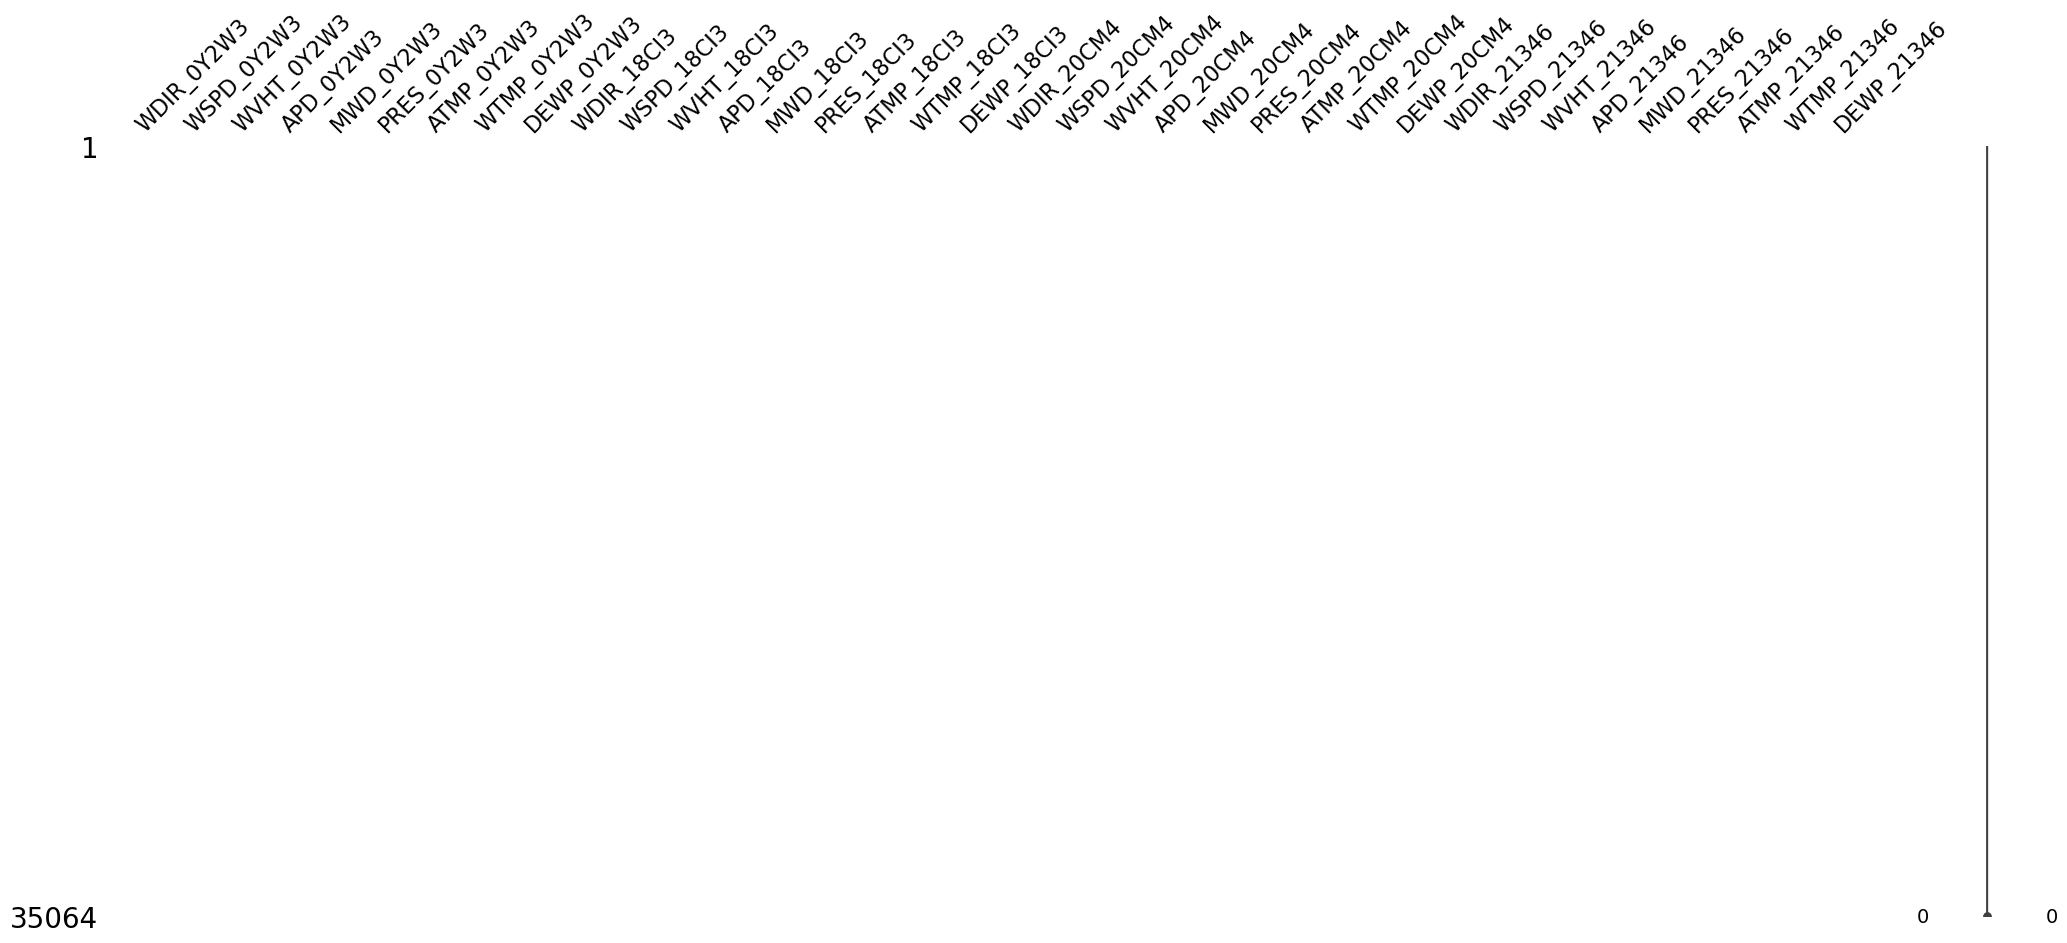

In [11]:
import missingno as msno
msno.matrix(dataset)

---
# Build ERA5 dataset

In [ ]:
# Note:
# it would also be possible to download several years in one step by changing the "year" parameter in mL.download_ERA5_singlePoint(). I decided to seperate them by years with the goal to get low redundance when storing data.

def build_ERA5_dataset(STATION_LIST, YEARS):
    data_list_annual = list()    # each element in this list is a df containing data of one certain year and all stations
    for year in YEARS:

        ERA5_data_list = list() # each element in this list is a df containing data of one certain year and one certain station.
        for station in STATION_LIST:
            ERA5_data = mL.get_ERA5_singlePoint(station, year)  # load file
            ERA5_data_list.append(ERA5_data)

        merged_ERA5_data = pd.concat(ERA5_data_list, axis=1, join="outer")  # outer join also includes NaN, inner join removes them
        data_list_annual.append(merged_ERA5_data)

    dataset_NDBC = pd.concat(data_list_annual, axis=0)
    return dataset_NDBC

In [ ]:
#df_ERA5 = mL.get_ERA5_singlePoint('venf1', '2020') # this is just a test

In [ ]:
dataset_ERA5 = build_ERA5_dataset(STATION_LIST, YEARS)

#TODO: change directory to data/datasets/...
#dataset_ERA5.to_csv(f'datasets/{filename}_ERA5.csv', index=False)
dataset_ERA5